# What we use in this code.
## 1. Gradient decent with Adam optimization.
## 2. 'He' initialization or Xavier initialization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pickle
import math
import mlxtend.data as mld

In [6]:
def loadDataset():
    path = 'F:/Books/Machine Learning/DataSets/DevanagariHandwrittenCharacterDataset/Train/*'
    train_l = []
    train_d = [] # pixels 32*32
    for label ,folder_name in enumerate(glob.glob(path)):
        for image in (glob.glob(folder_name+'/*')):
            imgdata = plt.imread(image).ravel()  # return (1024,) array  
            train_d.append(imgdata)
            train_l.append(label)
    # takes 20 sec
    
    path = 'F:/Books/Machine Learning/DataSets/DevanagariHandwrittenCharacterDataset/Test/*'
    test_l = []
    test_d = [] # pixels 32*32
    for label ,folder_name in enumerate(glob.glob(path)):
        for image in (glob.glob(folder_name+'/*')):
            imgdata = plt.imread(image).ravel()  # return (1024,) array  
            test_d.append(imgdata)
            test_l.append(label)
    # takes 10 sec

    return np.vstack(train_d) , np.vstack(test_d) , np.vstack(train_l) , np.vstack(test_l)

(78200, 1024)
(13800, 1024)
(78200, 1)
(13800, 1)


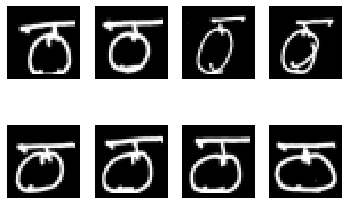

In [7]:
# takes approx. 30sec
X_train , X_test , y_train , y_test = loadDataset()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(X_train[4581+i,:].reshape(32,32), cmap='gray')
plt.show()

# Adam (Adaptive Moment Estimation)

It is an another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients vt like Adadelta and RMSProp. Adam also keeps an exponentially decaying average of past gradients mt similar to momentum.

Adam adds bias-correction and momentum to RMSProp

Adam is a combination of momentum + RMSProp which I covered already.

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  

In [8]:
class NeuralNetwork():
    
    def __init__(self):
        
        self.layers_n       = [] # no. of layers
        self.theta_layers   = [] # hidden layers weight list
        self.bias           = [] # hidden layers bias list
        
        self.s0             = [] # exponential weight for RMSProp it also works as a bias 
        self.sb             = [] # exponential bias for RMSProp
        self.v0             = [] # exponential weight for momentum it also works as a bias 
        self.vb             = [] # exponential bias for momentum
        
        self.activations    = [] # list of activations
        self.dL_dA          = [] # derivative w.r.t activations
        self.dL_dtheta      = [] # derivative w.r.t weights 
        self.dL_dbias       = [] # derivative w.r.t bias
        self.itera          = [] # store iterations
        self.csfun          = [] # store cost function values
        self.beta1          = 0.9   # momentum constant 
        self.beta2          = 0.99 # RMSProp constant
        self.epsilon        = 1e-7  # error adding
        self.seed           = 0 # random seed
        self.epoch          = 2
    def add(self , neuron ):
        self.layers_n.append(neuron)
        
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels
    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoch = 2,lmda = 0.01):
        self.epoch = epoch
        # He initialization [for Xavier initialization replace 2 with 1 in np.sqrt(2/self.layers_n[i])]
        for i in range(len(self.layers_n)-1): 
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]) * np.sqrt(1/self.layers_n[i]))
            self.s0.append(np.zeros([self.layers_n[i],self.layers_n[i+1]])) 
            self.v0.append(np.zeros([self.layers_n[i],self.layers_n[i+1]])) 
            
            self.bias.append(np.random.randn(self.layers_n[i+1]) * np.sqrt(1/self.layers_n[i]) )
            self.sb.append(np.zeros(self.layers_n[i+1]))
            self.vb.append(np.zeros(self.layers_n[i+1]))
        
        return self.randomMiniBatch( X , y , batch_size , alpha )
      
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)

    def forwardPropagation(self,X):
        
        self.activations    = []
        
        self.activations.append(X)
        for i in range(len(self.layers_n)-2):
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i]))
                      
        self.activations.append(self.softmax(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = self.y * np.log(self.activations[-1])
        np.nan_to_num(self.crossEntropy, copy=False)
        
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) 
      
    
    def backPropagation(self,X,y,alpha):
        
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        
        self.forwardPropagation(X)
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
             
            # Exponential weights and bias of momentum
            self.v0[i]               = (self.beta1 * self.v0[i]) +  ((1 - self.beta1) * self.dL_dtheta[-1-i])
            
            self.s0[i]               = (self.beta2 * self.s0[i]) +  ((1 - self.beta2) * np.square(self.dL_dtheta[-1-i]))
            
            # Exponential wights and bias of RMSProp
            self.vb[-1-i]            = (self.beta1 * self.vb[-1-i]) +  ((1 - self.beta1) 
                                                                       * (self.dL_dbias[i].sum(axis = 0)))
            self.sb[-1-i]            = (self.beta2 * self.sb[-1-i]) +  ((1 - self.beta2) 
                                                                       * np.square(self.dL_dbias[i].sum(axis = 0)))
            # weights and bias correction
            
            v0_c = self.v0[i] / (1 - np.power(self.beta1, self.epoch))
            vb_c = self.vb[-1-i] / (1 - np.power(self.beta1, self.epoch))
            
            s0_c = self.s0[i] / (1 - np.power(self.beta2, self.epoch))
            sb_c = self.sb[-1-i] / (1 - np.power(self.beta2, self.epoch))
            
            sqrt_s0  = np.sqrt(s0_c + self.epsilon)
            sqrt_sb  = np.sqrt(sb_c + self.epsilon)
            self.bias[-1-i]         -= (alpha * (vb_c.sum(axis = 0) / sqrt_sb.sum(axis = 0) ))                  
            self.theta_layers[i]    -= (alpha * (v0_c / sqrt_s0))  
            
            
    def randomMiniBatch(self, X, y, batch_size, alpha):              
        i = 0
        j = 1
        m = X.shape[0]
        np.random.seed(self.seed+i)
        while i < self.epoch:
       
            permutation = list(np.random.permutation(m))
            shuffled_X = X[permutation,:]               # shuffle data
            shuffled_Y = y[permutation].reshape((m,1))
            num_complete_minibatches = math.floor(m/batch_size) 

            # divide whole data into mini batches
            for k in range(0, num_complete_minibatches):
                
                mini_batch_X = shuffled_X[k * batch_size : (k + 1) * batch_size, :]
                mini_batch_Y = shuffled_Y[k * batch_size : (k + 1) * batch_size, :]
                cost = self.costFunction(mini_batch_X , mini_batch_Y )
       
                self.backPropagation(mini_batch_X, mini_batch_Y , alpha)
                    
                #print('Iteration {} Cost function {}'.format(j , cost ))    
                
                self.itera.append(j)
                self.csfun.append(cost)
                j +=1 
                
        
            if m % batch_size != 0:
                
                mini_batch_X = shuffled_X[num_complete_minibatches * batch_size: , :]
                mini_batch_Y = shuffled_Y[num_complete_minibatches * batch_size: , :]
                cost = self.costFunction(mini_batch_X , mini_batch_Y )
       
                self.backPropagation(mini_batch_X, mini_batch_Y , alpha )
                    
                #print('Iteration {} Cost function {}'.format(j , cost ))    
        
                self.itera.append(j+1)
                self.csfun.append(cost)
            i+=1
            print((i+1)," epoch",end=" ")
            print('Cost {}'.format(cost ))    
        
    
    def gradient_plot(self):
        plt.plot(self.itera[10:],self.csfun[10:])
        plt.show()
         
        
    def accuracy(self , X , y):
        self.forwardPropagation(X)
        pred = np.argmax(self.activations[-1],axis=1)
        c1 = 0
        for i,j in enumerate(y):
            if j == pred[i]:
                c1+=1
        print("Accuracy : ",(c1/y.shape[0])*100,'%')    


In [9]:
NN = NeuralNetwork()
NN.add(1024)
NN.add(512)
NN.add(512)
NN.add(46)
NN.fit(X_train , y_train , batch_size = 256 , alpha = 0.001 ,  epoch = 10)

2  epoch Cost 0.9818643768951726


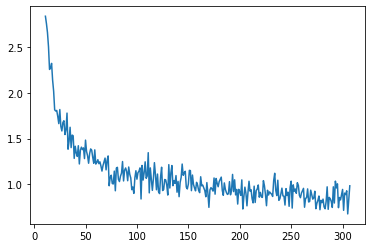

Accuracy :  79.14194373401534 %
Accuracy :  78.36231884057972 %


In [10]:
NN.gradient_plot()
NN.accuracy(X_train,y_train)
NN.accuracy(X_test,y_test)

In [12]:
train_data,train_label = mld.loadlocal_mnist(images_path='../../../DataSets/MNIST/train-images-mnist.idx3-ubyte', # extract
                        labels_path='../../../DataSets/MNIST/train-labels-mnist.idx1-ubyte')

test_data,test_label = mld.loadlocal_mnist(images_path='../../../DataSets/MNIST/test-images-mnist.idx3-ubyte', # extract 
                        labels_path='../../../DataSets/MNIST/test-labels-mnist.idx1-ubyte')

train_data = train_data/train_data.max()
test_data = test_data/test_data.max()

FileNotFoundError: [Errno 2] No such file or directory: '../../../DataSets/MNIST/train-labels-mnist.idx1-ubyte'

In [11]:
NN = NeuralNetwork()
NN.add(784)
NN.add(512)
NN.add(512)
NN.add(10)
NN.fit(train_data , train_label , batch_size = 256 , alpha = 0.002 ,  epoch = 10)

NameError: name 'train_data' is not defined

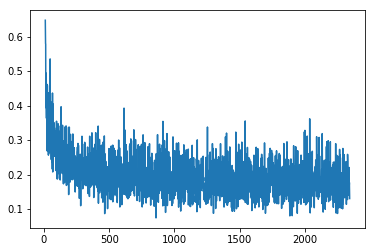

Accuracy :  95.18333333333334 %
Accuracy :  94.39 %


In [49]:
NN.gradient_plot()
NN.accuracy(train_data,train_label)
NN.accuracy(test_data,test_label)